# Manual gene knockout
Author: 
`Haroun Bensaadi`

In [2]:
%%capture
%run gene_annotation.ipynb

from colorama import init, Fore, Style
from cobra import Model, Reaction
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import factorial
from itertools import combinations
from IPython.display import display, clear_output
from itertools import combinations
from multiprocessing import Pool

model = read_sbml_model('Files/iCGB21FR_updated.xml')

#### Case 1: optimizing for MAX growth

In [3]:
model.objective = model.reactions.Growth
solution = model.optimize()
initial_growth, initial_lysine = solution['Growth'], solution['DAPDC']
print(f"Growth: {round(initial_growth, 6)} [1/h]")
print(f"Lysine: {round(initial_lysine, 6)} [mmol/gDW*h]")

Growth: 0.57066 [1/h]
Lysine: 0.189644 [mmol/gDW*h]


#### Case 2: optimzing for MAX lysine production

In [4]:
model.objective = model.reactions.DAPDC
solution = model.optimize()
initial_growth, initial_lysine = solution['Growth'], solution['DAPDC']
print(f"Growth: {round(initial_growth, 6)} [1/h]")
print(f"Lysine: {round(initial_lysine, 6)} [mmol/gDW*h]")

Growth: 0.0 [1/h]
Lysine: 9.433333 [mmol/gDW*h]


#### Case 3: optimizing for 80% of the MAX growth

In [5]:
model.objective = model.reactions.DAPDC

max_growth = 0.57066

model.reactions.Growth.bounds = (max_growth*0.8, 1000)
solution = model.optimize()

print(f"Growth: {round(solution['Growth'], 6)} [1/h]")
print(f"Lysine: {round(solution['DAPDC'], 6)} [mmol/gDW*h]")

Growth: 0.456528 [1/h]
Lysine: 2.915678 [mmol/gDW*h]


As it can be seen from the previous three cases, there is a tradeoff relationship between growth and the production of lysine:
- Maximizing for growth results in no production of lysine (not what we want)
- Maximizing for lysine production results in no growth (biologically unrealistic)
- Maximizing for 80% of grwoth results in both grwoth and the production of lysine, **howerver the choice of the value for limiting growth to 80% was completely arbitary** 

**Now the main questions are:** 

 - on which bases can the arbitary value of limiting the growth can be choosen?
 - what is the full tradeoff relationship between growth and lysine production across various values?**

To investigate this, we can plot the obtained results after **doing a parameter sensitivity analysis** by changing the value limiting growth **from 0% to 100%**.

In [40]:
%%time
factor_scan = []

for factor in np.arange(0.0, 1.0, 0.0001):
    
    model.objective = model.reactions.DAPDC
    model.reactions.Growth.bounds = (max_growth*factor, 1000)
    solution = model.optimize()

    factor_scan.append({
        "Growth": solution['Growth'],
        "lysine": solution['DAPDC'],
        "factor": factor
    })

df = pd.DataFrame(factor_scan, columns=["Growth", "lysine", "factor"])
df

Wall time: 3min 19s


,Growth,lysine,factor
0,0.000000,9.433333,0.0000
1,0.000057,9.432719,0.0001
2,0.000114,9.432105,0.0002
3,0.000171,9.431491,0.0003
4,0.000228,9.430877,0.0004
...,...,...,...
9995,0.570375,0.197595,0.9995
9996,0.570432,0.196005,0.9996
9997,0.570489,0.194415,0.9997
9998,0.570546,0.192825,0.9998


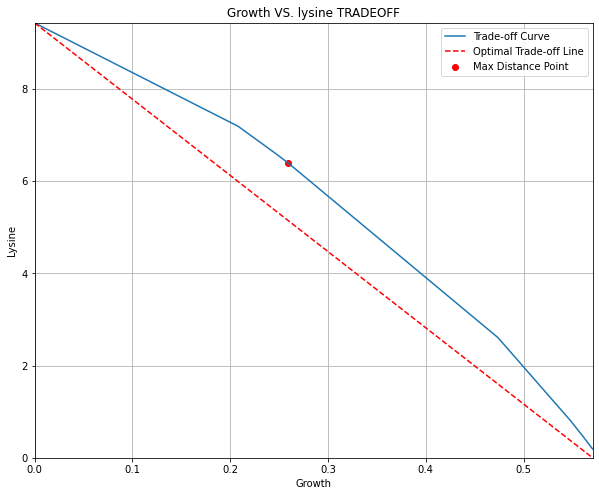

In [41]:
trade_off_curve = np.array([df['Growth'], df['lysine']]).T

line_start = np.array([0, max(df['lysine'])])
line_end = np.array([max(df['Growth']), 0])
line_vector = line_end - line_start
distances = np.abs(np.cross(line_vector, trade_off_curve - line_start)) / np.linalg.norm(line_vector)

max_distance_index = np.argmax(distances)
max_distance_point = trade_off_curve[max_distance_index]

plt.figure(figsize=(10, 8))

plt.plot(df['Growth'], df['lysine'], label='Trade-off Curve')
plt.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 'r--', label='Optimal Trade-off Line')
plt.scatter(max_distance_point[0], max_distance_point[1], color='red', label='Max Distance Point')

plt.title('Growth VS. lysine TRADEOFF')
plt.xlabel('Growth')
plt.ylabel('Lysine')
plt.xlim(0, max(df['Growth']))
plt.ylim(0, max(df['lysine']))
plt.legend()
plt.grid(True)
plt.show()

### Plot analysis
This plot highlight clearly the tradeoff relationship between growth and lysine production. **The obtained tradeoff curve follows a convex shape**, which can be highlited after ploting the diagonal line connecting the maximum lysine value on the y-axis to the maximum growth value on the x-axis.

**The search for an objective choice** of the optimal value maximing both growth and lysine production **can be seen mathimatically as calculating the perpendicular distance between the curve and the diagonal line, and finding the value that maximizes this this distance.**

In [44]:
print(f"Point with maximum perpondicular distance: {max_distance_point}")


Point with maximum perpondicular distance: [0.25919377 6.39716111]


In [52]:
optimal_growth, optimal_lysine = max_distance_point
optimal_factor = df.loc[max_distance_index, 'factor']

printText(f"Optimal factor for limiting growth: {round(optimal_factor*100, 9)}%", Fore.BLACK)
printText(f"Optimal growth: {round(optimal_growth, 6)} [1/h]", Fore.BLACK)
printText(f"Optimal lysine: {round(optimal_lysine, 6)} [mmol/gDW*h]", Fore.BLACK)


Optimal factor for limiting growth: 45.42%
Optimal growth: 0.259194 [1/h]
Optimal lysine: 6.397161 [mmol/gDW*h]


## Remark

**The earlier attempt to find a specific value for restricting growth might not perfectly mirror a real biological system. Nevertheless, it stands as the best effort we can make in this context, and more —certainly better than randomly choosing an arbitrary value like 80%.**

#### The below calculations are made using a restricted growth value of 0.259194 [1/h]

In [76]:
%%capture

model = read_sbml_model('Files/iCGB21FR_updated.xml')

In [77]:
model.reactions.Growth.bounds = (0.259193805 , 1000)
model.objective = model.reactions.DAPDC
solution = model.optimize()


print(f"Growth: {round(solution['Growth'], 6)} [1/h]")
print(f"Lysine: {round(solution['DAPDC'], 6)} [mmol/gDW*h]")

Growth: 0.259194 [1/h]
Lysine: 6.397161 [mmol/gDW*h]


## Single KO

In [17]:
%%time

single_KO_results = []

N = len(model.genes)
i = 0

for gene in model.genes:
    with model:
        i+=1
        gene.knock_out()        
        protein_id = getProteinID(gene.id)
        
        solution = model.optimize()
        single_KO_results.append({
            "protein_id": protein_id,
            "growth": solution['Growth'],
            "lysine": solution['DAPDC']
        })

    progress_text = f"Progress: {round(i/N*100, 2)}%"
    clear_output(wait=True)
    display(progress_text)
    
clear_output()
print("Single KO completed!")

df_single_KO = pd.DataFrame(single_KO_results, columns=["protein_id", "growth", "lysine"])
df_single_KO

Single KO completed!
Wall time: 22.5 s


,protein_id,growth,lysine
0,WP_011015468,0.259194,6.397161
1,WP_003855288,0.259194,6.397161
2,WP_011013917,0.259194,6.397161
3,WP_003859251,0.259194,5.880308
4,WP_011015386,0.259194,6.397161
...,...,...,...
802,WP_011013607,0.259194,6.337323
803,WP_011013606,0.259194,6.337323
804,WP_011014733,0.259194,6.397161
805,None,0.259194,6.397161


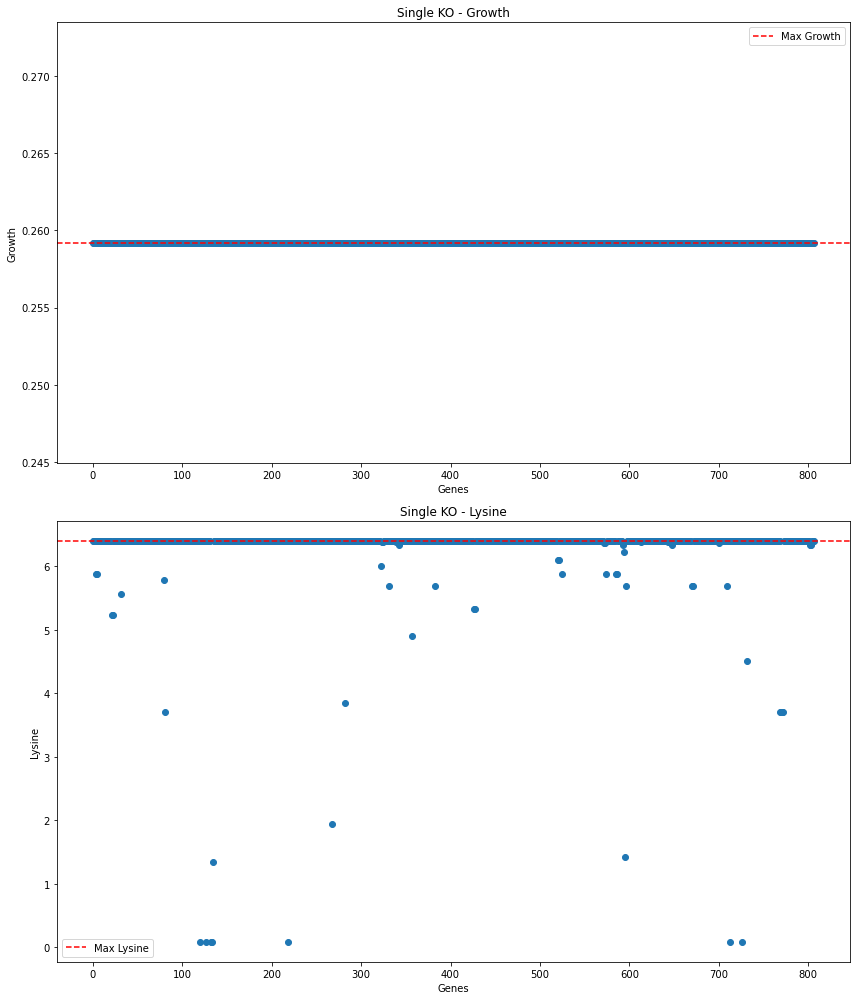

In [38]:
plt.figure(figsize=(12, 14))

plt.subplot(2, 1, 1)
plt.scatter(df_single_KO.index, df_single_KO["growth"])
plt.axhline(y=0.259194, color='r', linestyle='--', label='Max Growth')
plt.xlabel("Genes")
plt.ylabel("Growth")
plt.title("Single KO - Growth")
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(df_single_KO.index, df_single_KO["lysine"])
plt.axhline(y=6.397161, color='r', linestyle='--', label='Max Lysine')
plt.xlabel("Genes")
plt.ylabel("Lysine")
plt.title("Single KO - Lysine")
plt.legend()

plt.tight_layout()
plt.show()

### Plot analysis
**Genes vs. Growth:**

The single knockout made manually **kept growth at the same previous value** of 0.259194 [1/h]. This suggests that the removal of a single gene did not lead to an improvement or reduction in the growth rate.

**Genes vs. Lysine:**

The single knockout made manually **didn't imporve lysine production**, all mutants had either the same previous lysine production value of 6.397161 [mmol/gDW*h] or lower than that. This implies that the removal of individual genes did not result in an increase in lysine production and, in some cases, led to a decrease.

## Double KO

In [6]:
model.reactions.Growth.bounds = (0.259193805 , 1000)
model.objective = model.reactions.DAPDC
solution = model.optimize()


print(f"Growth: {round(solution['Growth'], 6)} [1/h]")
print(f"Lysine: {round(solution['DAPDC'], 6)} [mmol/gDW*h]")

Growth: 0.259194 [1/h]
Lysine: 6.397161 [mmol/gDW*h]


In [7]:
%%time

n = len(model.genes)
k = 2
total_double_ko_combinations = factorial(n) // (factorial(k) * factorial(n - k))
print(f"Total number of double KO with {n} genes is: {total_double_ko_combinations}")


N = total_double_ko_combinations
i = 0

double_KO_results = []

for gene1, gene2 in combinations(model.genes, 2):
    i+=1
    with model:
        gene1.knock_out()
        gene2.knock_out()

        protein_id_1 = getProteinID(gene1.id)
        protein_id_2 = getProteinID(gene2.id)

        solution = model.optimize()

        double_KO_results.append({
            "protein_id_1": protein_id_1,
            "protein_id_2": protein_id_2,
            "growth": solution['Growth'],
            "lysine": solution['DAPDC']
        })

    progress_text = f"Progress: {round(i/N*100, 3)}%"
    clear_output(wait=True)
    display(progress_text)
    
clear_output()
print("Double KO completed!")

df_double_KO = pd.DataFrame(double_KO_results, columns=["protein_id_gene1", "protein_id_gene2", "growth", "lysine"])
df_double_KO

Double KO completed!
Wall time: 2h 58min 57s


,protein_id_gene1,protein_id_gene2,growth,lysine
0,NaN,NaN,0.259194,6.397161
1,NaN,NaN,0.259194,6.397161
2,NaN,NaN,0.259194,5.880308
3,NaN,NaN,0.259194,6.397161
4,NaN,NaN,0.259194,5.880308
...,...,...,...,...
325216,NaN,NaN,0.259194,6.337323
325217,NaN,NaN,0.259194,6.337323
325218,NaN,NaN,0.259194,6.397161
325219,NaN,NaN,0.259194,6.397161


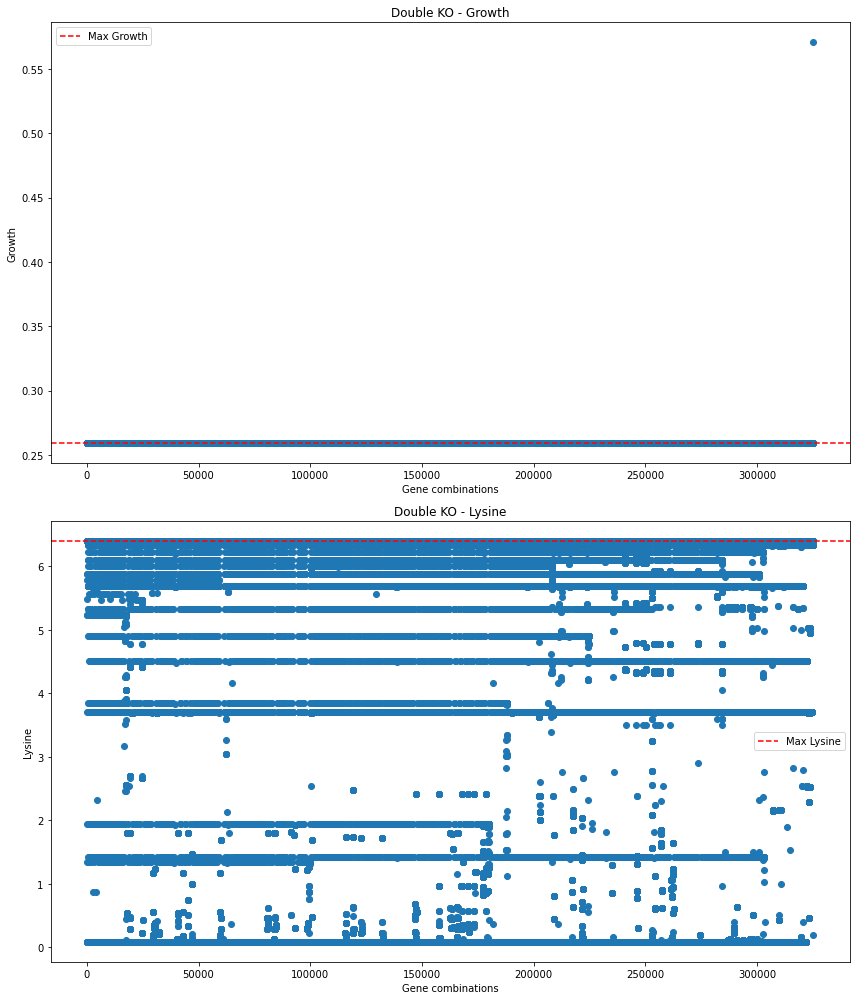

In [37]:
plt.figure(figsize=(12, 14))
plt.subplot(2, 1, 1)

plt.scatter(df_double_KO.index, df_double_KO["growth"])
plt.axhline(y=0.259194, color='r', linestyle='--', label='Max Growth')
plt.xlabel("Gene combinations")
plt.ylabel("Growth")
plt.title("Double KO - Growth")
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(df_double_KO.index, df_double_KO["lysine"])
plt.axhline(y=6.397161, color='r', linestyle='--', label='Max Lysine')
plt.xlabel("Gene combinations")
plt.ylabel("Lysine")
plt.title("Double KO - Lysine")
plt.legend()

plt.tight_layout()
plt.show()

### Plot analysis:
Same remarks as for the single KO 